__David Sivieri__  
__CSC8200 Health Informatics & EHealth Systems__  
__Final Project__

# Project Description and Goal

In [1]:
import re
import math
import sys
import numpy as np
import pandas as pd

from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from sklearn.model_selection import RepeatedKFold
import scipy
import sklearn

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.max_rows", 1000000)
pd.set_option("display.max_columns", 1000000)
pd.set_option("display.width", 1000000)
pd.set_option("display.max_colwidth", 1000000)
pd.set_option("display.max_info_columns", 1000)
np.set_printoptions(threshold=sys.maxsize)

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

import qgrid

In [2]:
%%HTML
<style type="text/css">
    table.dataframe td, table.dataframe th {
        border-style: solid;
        border: 1px solid lightgray;
    }
    tr:nth-child(even) {
        background: #eee;
    }
    th {
       background-color: lemonchiffon;
       color: black;
}
</style>

In [3]:
# df = pd.read_csv("diabetic_data.csv", header=0, index_col=["patient_nbr", "encounter_id"])
# for col_name in df.select_dtypes(include="int64").columns:
#     df[col_name] = pd.to_numeric(df[col_name], downcast="integer")

# left_age = df.age.str.extract(pat=r"^\[([0-9]+)").astype("int")
# right_age = df.age.str.extract(pat=r"([0-9]+)\)$").astype("int")

# df["imputed_age"] = (right_age - left_age) / 2 + left_age
# df["imputed_age"] = pd.to_numeric(df["imputed_age"], downcast="integer")

# df.sort_values(by=["patient_nbr", "encounter_id"], inplace=True)

# df.to_pickle("diabetic_data.pkl")

In [4]:
df = pd.read_pickle("diabetic_data.pkl")

In [19]:
df_summary = df[["race", "gender", "age", "readmitted", "time_in_hospital", "number_inpatient", "number_outpatient", "number_emergency"]]

qgrid.show_grid(df_summary.head(500), show_toolbar=True, grid_options={"forceFitColumns": False})
#df_summary.head(500)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [6]:
continuous_cols = ["time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses"]
df[continuous_cols].describe().T.round(2).drop(["count"], axis=1)

,mean,std,min,25%,50%,75%,max
time_in_hospital,4.40,2.99,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,43.10,19.67,1.0,31.0,44.0,57.0,132.0
num_procedures,1.34,1.71,0.0,0.0,1.0,2.0,6.0
num_medications,16.02,8.13,1.0,10.0,15.0,20.0,81.0
number_outpatient,0.37,1.27,0.0,0.0,0.0,0.0,42.0
number_emergency,0.20,0.93,0.0,0.0,0.0,0.0,76.0
number_inpatient,0.64,1.26,0.0,0.0,0.0,1.0,21.0
number_diagnoses,7.42,1.93,1.0,6.0,8.0,9.0,16.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 101766 entries, (135, 24437208) to (189502619, 371459060)
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   weight                    101766 non-null  object
 4   admission_type_id         101766 non-null  int8  
 5   discharge_disposition_id  101766 non-null  int8  
 6   admission_source_id       101766 non-null  int8  
 7   time_in_hospital          101766 non-null  int8  
 8   payer_code                101766 non-null  object
 9   medical_specialty         101766 non-null  object
 10  num_lab_procedures        101766 non-null  int16 
 11  num_procedures            101766 non-null  int8  
 12  num_medications           101766 non-null  int8  
 13  number_outpatient         101

In [8]:
df_attrib = df.nunique().to_frame(name="Number of unique values")
df_attrib.index.names = ["ATTRIBUTE NAME"]
df_attrib

,Number of unique values
ATTRIBUTE NAME,
race,6
gender,3
age,10
weight,10
admission_type_id,8
discharge_disposition_id,26
admission_source_id,17
time_in_hospital,14
payer_code,18


In [9]:
def generate_val_cnts(input_df, col_header):
    df_temp = input_df.value_counts().to_frame(name="Count").join(input_df.value_counts(normalize=True).to_frame(name="Proportion"))
    df_temp.Proportion = (df_temp.Proportion * 100).map("{:.2f}%".format)
    df_temp.index.names = [col_header]
    return df_temp

In [10]:
df_readmit = generate_val_cnts(df.readmitted, "Readmitted in (days)")
df_readmit
# df_readmit.to_clipboard()

,Count,Proportion
Readmitted in (days),,
NO,54864,53.91%
>30,35545,34.93%
<30,11357,11.16%


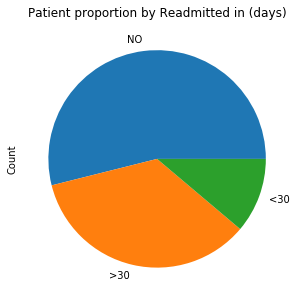

In [11]:
plot = df_readmit.Count.plot.pie(y="Race", figsize=(5, 5), title="Patient proportion by Readmitted in (days)")

In [12]:
df_race = generate_val_cnts(df.race, "Race")
df_race
# df_race.to_clipboard()

,Count,Proportion
Race,,
Caucasian,76099,74.78%
AfricanAmerican,19210,18.88%
?,2273,2.23%
Hispanic,2037,2.00%
Other,1506,1.48%
Asian,641,0.63%


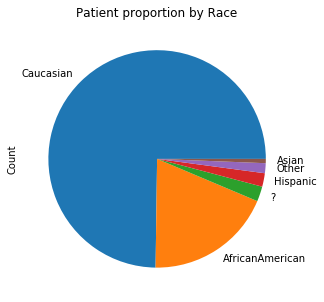

In [13]:
plot = df_race.Count.plot.pie(y="Race", figsize=(5, 5), title="Patient proportion by Race")

In [14]:
df_gender = generate_val_cnts(df.gender, "Gender")
df_gender
# df_gender.to_clipboard()

,Count,Proportion
Gender,,
Female,54708,53.76%
Male,47055,46.24%
Unknown/Invalid,3,0.00%


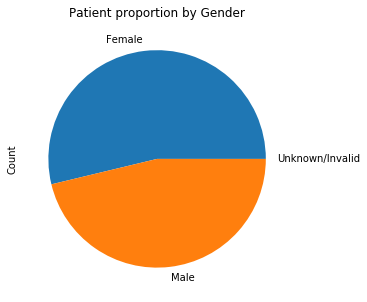

In [15]:
plot = df_gender.Count.plot.pie(y="Gender", figsize=(5, 5), title="Patient proportion by Gender")

In [16]:
df_age = generate_val_cnts(df.age, "Age")
df_age.sort_values(by="Age")
# df_age.to_clipboard()

,Count,Proportion
Age,,
[0-10),161,0.16%
[10-20),691,0.68%
[20-30),1657,1.63%
[30-40),3775,3.71%
[40-50),9685,9.52%
[50-60),17256,16.96%
[60-70),22483,22.09%
[70-80),26068,25.62%
[80-90),17197,16.90%


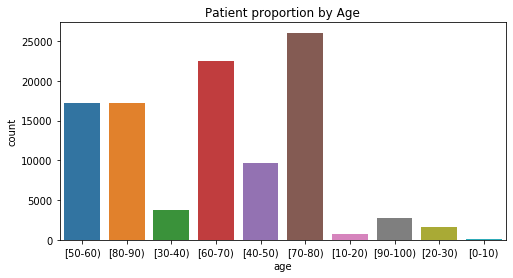

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(ax=ax, x="age", data=df)
ax.set_title("Patient proportion by Age")
plt.show()

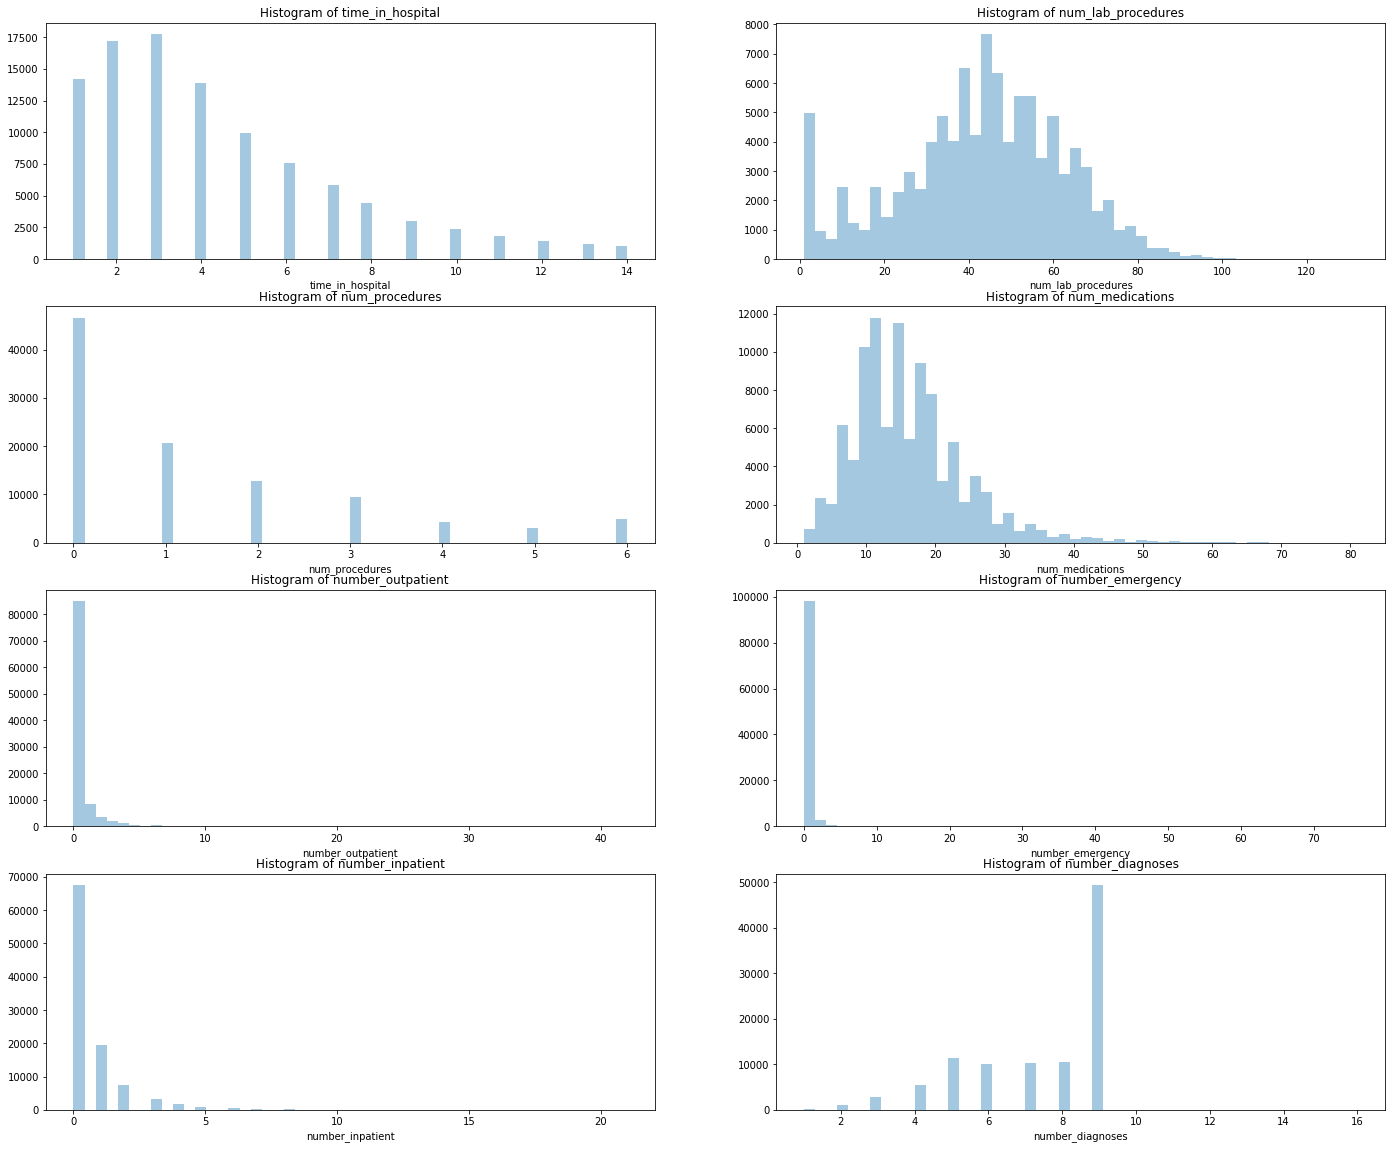

In [18]:
fig, axs = plt.subplots(4, 2, figsize=(24, 20))

for ax, col in zip(axs.flatten(), continuous_cols[:]):
    sns.distplot(df[col], ax=ax, kde=False)
    ax.set_title(str("Histogram of " + col))

plt.show()